# Assignment 1 — Lars van den Heuvel  
### *Exploring Real-World Networks*

---

**Course:** Model Based Decisions (2025) — *MSc Complex Systems & Policy*  
**Lecturer:** Michael Lees  

---

**Datacollectors & Credits:**  
>J. Leskovec, D. Huttenlocher, J. Kleinberg. *Signed Networks in Social Media.* CHI 2010.  
>J. Leskovec, D. Huttenlocher, J. Kleinberg. *Predicting Positive and Negative Links in Online Social Networks.* WWW 2010.

>Link to website:https://snap.stanford.edu/data/wiki-Vote.html



In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# -------------------------------------------------------------
# Load and create the wiki-Vote network
# -------------------------------------------------------------
def load_wikivote_data(filepath):
    print("Loading wiki-Vote data...")
    G = nx.read_edgelist(
        filepath,
        comments="#",
        create_using=nx.DiGraph(),
        nodetype=int
    )
    print(f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G



In [11]:
# -------------------------------------------------------------
# Compute summary statistics
# -------------------------------------------------------------
def network_summary(G):
    print("\n" + "="*60)
    print("NETWORK SUMMARY")
    print("="*60)

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Directed: {G.is_directed()}")

    # Largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(largest_cc).copy()
    print(f"Largest component: {Gcc.number_of_nodes()} nodes, {Gcc.number_of_edges()} edges")

    density = nx.density(Gcc)
    clustering = nx.average_clustering(Gcc.to_undirected())
    assort = nx.degree_assortativity_coefficient(Gcc.to_undirected())
    print(f"Density: {density:.6f}")
    print(f"Average clustering coefficient: {clustering:.4f}")
    print(f"Assortativity: {assort:.3f}")

    try:
        apl = nx.average_shortest_path_length(Gcc.to_undirected())
        print(f"Average shortest path length: {apl:.2f}")
    except Exception as e:
        print(f"Could not compute path length: {e}")

In [12]:
# -------------------------------------------------------------
# Degree distribution
# -------------------------------------------------------------
def plot_degree_distribution(G):
    print("Plotting degree distribution...")
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = Counter(degrees)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.bar(degree_counts.keys(), degree_counts.values(), color='skyblue', edgecolor='black')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution (Linear)")

    plt.subplot(1,2,2)
    plt.loglog(list(degree_counts.keys()), list(degree_counts.values()), 'bo', alpha=0.7)
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.title("Degree Distribution (Log-Log)")

    plt.tight_layout()
    plt.show()

    print(f"Mean degree: {np.mean(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")


In [ ]:
#Make functions for the three network models

In [13]:
# -------------------------------------------------------------
# Centrality measures
# -------------------------------------------------------------
def calculate_centrality_measures(G):
    print("\nCalculating centrality measures...")
    centralities = {}

    # Convert to largest component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(largest_cc).copy()

    centralities['degree'] = nx.degree_centrality(Gcc)
    centralities['betweenness'] = nx.betweenness_centrality(Gcc, k=500)  # sampling
    centralities['closeness'] = nx.closeness_centrality(Gcc)
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(Gcc.to_undirected(), max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("Eigenvector centrality failed to converge; using PageRank instead")
        centralities['eigenvector'] = nx.pagerank(Gcc)

    return centralities

def display_top_nodes(centralities, top_n=10):
    print("\n" + "="*60)
    print(f"TOP {top_n} USERS BY CENTRALITY")
    print("="*60)
    for measure, values in centralities.items():
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        print(f"\n{measure.upper()} CENTRALITY")
        print("-"*40)
        for i, (node, val) in enumerate(top_nodes, 1):
            print(f"{i:2d}. Node {node} - {val:.6f}")

Loading wiki-Vote data...
Loaded network with 7115 nodes and 103689 edges.

NETWORK SUMMARY
Number of nodes: 7115
Number of edges: 103689
Directed: True
Largest component: 7066 nodes, 103663 edges
Density: 0.002077
Average clustering coefficient: 0.1419
Assortativity: -0.083
Average shortest path length: 3.25
Plotting degree distribution...


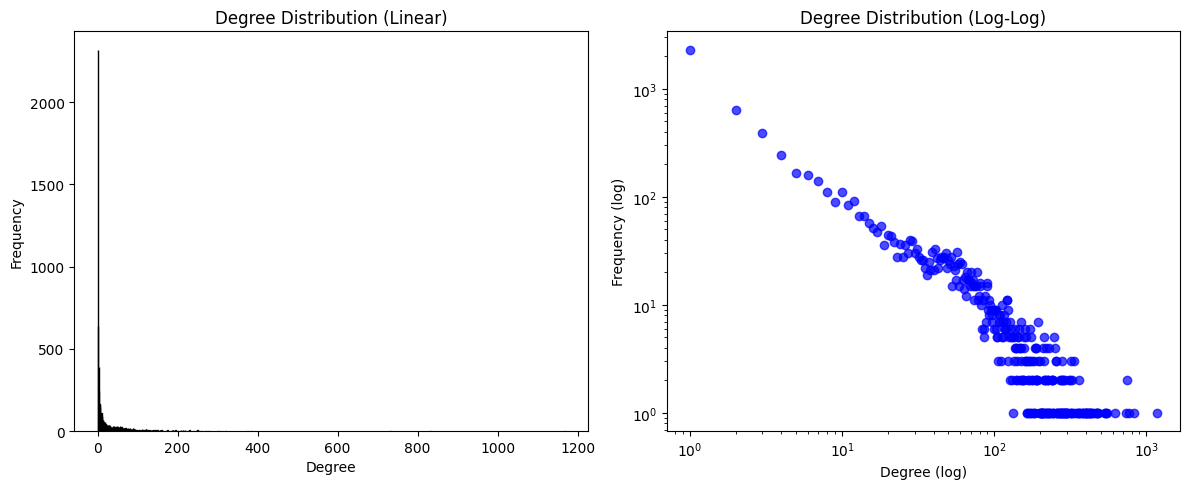

Mean degree: 29.15
Max degree: 1167

Calculating centrality measures...

TOP 10 USERS BY CENTRALITY

DEGREE CENTRALITY
----------------------------------------
 1. Node 2565 - 0.165180
 2. Node 1549 - 0.117764
 3. Node 766 - 0.109413
 4. Node 11 - 0.105166
 5. Node 1166 - 0.105166
 6. Node 457 - 0.103609
 7. Node 2688 - 0.087473
 8. Node 1374 - 0.077990
 9. Node 1151 - 0.076858
10. Node 5524 - 0.076150

BETWEENNESS CENTRALITY
----------------------------------------
 1. Node 2565 - 0.017361
 2. Node 1549 - 0.015865
 3. Node 15 - 0.009386
 4. Node 72 - 0.007815
 5. Node 737 - 0.006783
 6. Node 1166 - 0.005951
 7. Node 2237 - 0.005419
 8. Node 993 - 0.005414
 9. Node 28 - 0.005147
10. Node 2328 - 0.004988

CLOSENESS CENTRALITY
----------------------------------------
 1. Node 4037 - 0.298539
 2. Node 15 - 0.293511
 3. Node 2398 - 0.292940
 4. Node 1549 - 0.283882
 5. Node 2535 - 0.281842
 6. Node 3089 - 0.279976
 7. Node 762 - 0.279935
 8. Node 5412 - 0.279745
 9. Node 2565 - 0.279540
10

In [14]:
# -------------------------------------------------------------
# Main workflow
# -------------------------------------------------------------
def main():
    file = "C:/Users/lars_/MBDM/Week 2 - Networks/datasets/wiki-Vote.txt.gz"
    G = load_wikivote_data(file)
    network_summary(G)
    plot_degree_distribution(G)
    centr = calculate_centrality_measures(G)
    display_top_nodes(centr)

if __name__ == "__main__":
    main()


In [15]:
#ASK QUESTION ABOUT NOT PRINTING CLOSENESS AND EIGENVECTORS THAT WERE TRUNCADED OR WHATEVER